# Exploratory Data Analysis
This notebook creates features from raw tables and visualizes the results.

## 1. Set environment
Import libraries

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install isodate
    !pip install vaderSentiment
    !pip install stargazer
    !git clone https://github.com/ArturoSbr/youtube-dislike-count
    %cd youtube-dislike-count/cod/02_analysis

In [2]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer

Read datasets

In [3]:
d1 = pd.read_csv('../../dat/videoDetails.csv')
d2 = pd.read_csv('../../dat/videoFlags.csv')
df = pd.merge(d1, d2, on='videoId', how='right')

Data summary

In [4]:
nvids = d2['videoId'].nunique()
ncoms = round(df['post12CommentsNum'].sum(), -5)

print(f'Scraped {int(ncoms)} from {nvids} Political videos.')

Scraped 500000 from 1533 Political videos.


## 2. Feature creation
Add constant term

In [5]:
df['const'] = 1

Convert `publishedAt` to datetime format

In [6]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

Turn `definition` to dummy

In [7]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create targets from counters

In [8]:
# Hours (12, 24, 36, ...)
hours = list(np.arange(12, 72+1, 12))

# NCR and sNCR
for h in hours:
    df[f'ncr1Post{h}'] = df[f'post{h}CommentsNeg1'] / df[f'post{h}CommentsNum'].replace(0, 0.1)
    df[f'ncr2Post{h}'] = df[f'post{h}CommentsNeg2'] / df[f'post{h}CommentsNum'].replace(0, 0.1)

Analyze most important words in video titles to create dummy variables

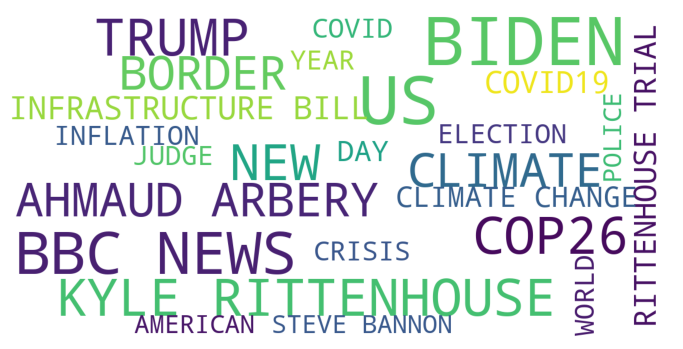

In [9]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()
# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS','S'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

# Show wordcloud
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Create dummy variables by topic

In [10]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
topics = {
    'president':'biden|trump',
    'climate':'cop26|cop 26|climate',
    'economy':'inflation|infrastructure|bill|economy',
    'covid':'covid|covid19|covid-19|virus',
    'violence':'kill|murder|assassins| die|dead|shoot|shot'
}

# Create Indicator variables
for topic in topics.keys():
    df[topic] = np.where(df['title'].str.contains(topics[topic]), 1, 0)

Video title sentiment

In [11]:
clf = SentimentIntensityAnalyzer()
df['toneCom'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])
df['tonePos'] = df['title'].apply(lambda x: clf.polarity_scores(x)['pos'])
df['toneNeg'] = df['title'].apply(lambda x: clf.polarity_scores(x)['neg'])

Translate `duration` to seconds.

In [12]:
# YT-duration format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Sort data by upload date

In [13]:
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

Treatment indicator

In [14]:
df['treat'] = (df['publishedAt'] > '2021-11-10').astype(int)

Declare running variable $R_i$ and interaction term $R_i \times T_i$
- Before: Seconds until treatment (control was positive, treatment was negative)
- Update: Seconds since treatment (control is negative, treatment is positive)

In [15]:
# Running variable
df['r'] = (df['publishedAt'] - pd.Timestamp('2021-11-10')).dt.total_seconds()

# Interaction
df['rTreat'] = df['r'].multiply(df['treat'])

## 3. Balance tests
List of targets

In [16]:
windows = [f'Post{h}' for h in hours]

### 3.1. Descriptive statistics
Number of available videos as a function of $h$

In [17]:
# post{h}CommentsNum
cols = [f'post{str(h)}CommentsNum' for h in hours]

# Merge to get videoId & post{h}CommentsNum
t = pd.merge(d1[['videoId','publishedAt']], d2[['videoId'] + cols], on='videoId', how='left')

# Create C&T groups
t['treat'] = (t['publishedAt'] > '2021-11-10').astype(int)

# Count available videos per window
t[cols] = t[cols].notna().astype(int)

# Group by
t = t.groupby('treat').agg({**{'videoId':'size'}, **dict(zip(cols,['sum']*6))}).transpose()

# Format
t.index = ['Total videos'] + ['h = ' + str(i*12) for i in range(1,7)]
t

# To latex
# print(t.to_latex(caption='Number of available videos for different values of $h$',
#                  label='tab_dat_nobs'))

treat,0,1
Total videos,831,899
h = 12,678,855
h = 24,583,855
h = 36,463,855
h = 48,428,855
h = 60,344,855
h = 72,319,855


### 3.2. Balance

Balance table for videos closest to the cutoff: $R_{hours} \in [-36,-12] \cup [24,36]$

1. Difference in means for binary covariates
1. RDD for continuous covariates

$$X_i = \gamma_0 + \gamma_1 r_i + \gamma_2 T_i + \gamma_3 r_i T_i + V_i$$

In [18]:
# Bandwidth
d = df[df['r'].between(-36*60*60, -12*60*60) | df['r'].between(24*60*60, 48*60*60)]

# Order frequent-word variables by frequency
X = list(topics.keys()) + ['definition','seconds','tonePos','toneNeg','toneCom']

# Regress each variable on r and treat
data = []
for x in X:
    m = sm.OLS(endog=d[x], exog=d[['const','r','treat','rTreat']]).fit()
    data.append((m.params['treat'], m.pvalues['treat']))

# Summary table
t = pd.DataFrame(data=data, index=X, columns=['Estimated Value','p-value'])
t.round(2)

,Estimated Value,p-value
president,0.36,0.01
climate,0.07,0.50
economy,0.13,0.22
covid,-0.01,0.86
violence,-0.15,0.21
definition,0.23,0.13
seconds,-499.36,0.62
tonePos,0.00,0.99
toneNeg,0.03,0.65
toneCom,-0.02,0.91


## 4. Regression Analysis
Fit all polynomial models with $d \in \{1, 2\}$.

### 4.1. First-degree
$Y_i = \beta_0 + \beta_1 r_i + \beta_2 T_i + \beta_3 T_i \times r_i + \gamma X_i + U_i$

In [107]:
# Minumum number of comments
mask = df['post12CommentsNum'] > 0

# FIt all models
d1 = []
for target in ['ncr1','ncr2']:
    for window in windows:
        formula = f'{target}{window} ~ treat + r + I(r * treat)'
        m = sm.OLS.from_formula(formula=formula, data=df[mask]).fit(cov_type='HC0')
        d1.append(m)

$NCR(h)$ summary

In [112]:
# Summaries
ncr1 = Stargazer(d1[:6])
ncr1.dependent_variable_name('Dependent Variable: Negative Comment Ratio')
ncr1.custom_columns([f'h = {h}' for h in hours], [1]*6)
ncr1.covariate_order(['treat','r','I(r * treat)','Intercept'])#,'toneNeg'])
ncr1.rename_covariates({'I(r * treat)':'RxT','r':'R','treat':'T'})#,'toneNeg':'Negative tone'})
ncr1.show_degrees_of_freedom(False)
ncr1.add_custom_notes(['Robust standard errors (HC0)'])
ncr1

# Latex output
# print(ncr1.render_latex())

$sNCR(h)$ summaries

In [113]:
# Model summaries
ncr2 = Stargazer(d1[6:])
ncr2.dependent_variable_name('Dependent Variable: Somewhat Negative Comment Ratio')
ncr2.custom_columns([f'h = {h}' for h in hours], [1]*6)
ncr2.covariate_order(['treat','r','I(r * treat)','Intercept'])#,'toneNeg'])
ncr2.rename_covariates({'I(r * treat)':'RxT','r':'R','treat':'T'})#,'toneNeg':'Negative tone'})
ncr2.show_degrees_of_freedom(False)
ncr2.add_custom_notes(['Robust standard errors (HC0)'])
ncr2

# Latex output
# print(ncr2.render_latex())

### 4.2. Second-degree
$$Y_i = \beta_0 + \beta_1 T_i + \beta_1 R_i + \beta_2 R_i^2 + \beta_3 (T_i \times R_i) + \beta_4 (T_i \times R_i^2) + \gamma X_i + U_i$$

In [103]:
# Fit all models
d2 = []
for target in ['ncr1','ncr2']:
    for window in windows:
        formula = f'{target}{window} ~ treat + r + I(r**2) + I(r * treat) + I((r**2) * treat)'
        m = sm.OLS.from_formula(formula=formula, data=df[mask]).fit(cov_type='HC0')
        d2.append(m)

### 3.2. Visualizations
Linear and quadratic RDD for $NCR(12)$

In [121]:
# Data and predictions
t = pd.DataFrame({'r':df.loc[mask, 'r'],
                  'l':d1[0].fittedvalues.values,
                  'q':d2[0].fittedvalues.values})
t['treat'] = (t['r'] > 0).astype(int)

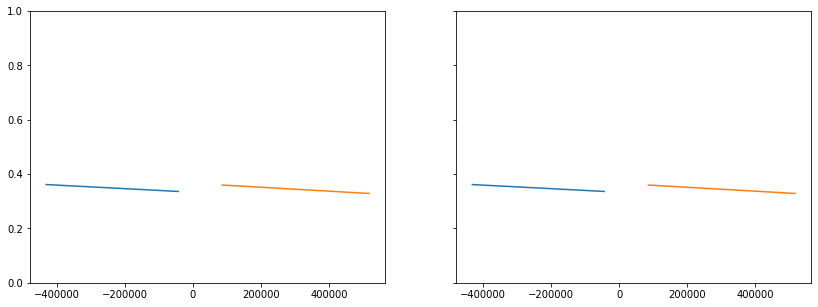

In [125]:
# Initialize figure
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(14)

# Data for plot (binned by X hours)
d = df[['ncr1Post12','r']].copy()
d['bin'] = (d['r'].div(60*60) / 4).apply(lambda x: floor(x))
d = d.groupby('bin')['ncr1Post12'].mean().reset_index(name='mean')
d['bin'] = d['bin'].multiply(4*60*60)

# Plot model on each axis
for i, ax in enumerate(axs):
    # Plot linear model
    if i == 0:
        ax = axs[0]
        series = 'l'
    else:
        ax = axs[1]
        series = 'q'
    ax.plot(t.loc[t['treat'].eq(0), 'r'], t.loc[t['treat'].eq(0), series])
    ax.plot(t.loc[t['treat'].eq(1), 'r'], t.loc[t['treat'].eq(1), series])
    
#     ax.scatter(d['bin'], d['mean'], alpha=0.6)
#     ax.axvspan(xmin=0, xmax=24*60*60, color='gray', alpha=0.3)
#     ax.axvspan(xmin=-12*60*60, xmax=0, color='C0', alpha=0.3)
#     ax.set_xticks(np.arange(-30, 37, 6))
#     ax.set_xticklabels(ax.get_xticks() * 4)

plt.ylim(0, 1)
plt.show()

In [123]:
t.loc[t['treat'].eq(0)]

,r,l,q,treat
678,86411.0,0.359706,0.372210,1
679,86494.0,0.359700,0.372190,1
681,87102.0,0.359657,0.372040,1
682,87310.0,0.359642,0.371989,1
683,88606.0,0.359549,0.371671,1
...,...,...,...,...
1528,517634.0,0.328732,0.338886,1
1529,518095.0,0.328699,0.338929,1
1530,518125.0,0.328697,0.338931,1
1531,518148.0,0.328695,0.338933,1


In [76]:
l = d1[0]
q = d2[0]

In [78]:
l.params

Intercept       3.056915e-01
treat           3.525024e-02
r              -6.073159e-08
I(r * treat)   -2.171228e-08
toneNeg         2.342548e-01
dtype: float64

In [77]:
l.predict([-120*60*60 + ])

TypeError: object of type 'int' has no len()

In [ ]:
# Columns that contain 'ncr'
cols = [col for col in df.columns if 'ncr' in col]

# Initialize figure
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(14)

# Plot within each axis
for i, ax in enumerate(axs.flatten()):
    # Only videos with post12CommentsNum > 15
    m = df['post12CommentsNum'].ge(15)
    # Time series
    x = df.loc[m, 'publishedAt']
    y = df.loc[m, cols[i]]
    color = 'tomato' if i % 2 == 0 else 'coral'
    ax.scatter(x, y, alpha=0.5, color=color)
    # Banned treatment region
    ax.axvspan(xmin=pd.Timestamp('2021-11-10'), xmax=pd.Timestamp('2021-11-11'),
               color='grey', alpha=0.5)
    # Ticks and labels
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    # Aesthetics
    title = 'Negative Comment Ratio' if i % 2 == 0 else 'Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(title + ' (h = ' + h + ')')
    ax.grid(which='major', axis='x')
# if 'google.colab' not in sys.modules:
#     plt.savefig('../../fig/fig_pres_targets.png', dpi=200, bbox_inches='tight')
plt.show()

Average NCR per hourly bin
- Video posted 45 minutes before treatment gets bin = -1 hour
- Video posted 45 minutes after treatment gets bin = 1 hour

$$ncr_i = \beta_0 + \beta_1 r_i + \beta_2 r_i^2 + \beta_3 r_i^3 + T_i(\beta_4 + \beta_5 r_i + \beta_6 r_i^2 + \beta_7 r_i^3)$$

Group data by hourly-bins

In [ ]:
# Ceiling of hours until treatment (in 4h bins)
df['bin'] = df['r'].div(60*60).apply(lambda x: floor(x))

# Average NCR
t = df[df['post12CommentsNum'].ge(0)].groupby('bin')[cols].mean()

# Columns for regression
t = t.assign(const = 1,
             r1 = t.index,
             r2 = np.power(t.index, 2),
             r3 = np.power(t.index, 3),
             t = np.where(t.index > 0, 0, 1))
t = t.assign(tr1 = t['t'].multiply(t['r1']),
             tr2 = t['t'].multiply(t['r2']),
             tr3 = t['t'].multiply(t['r3']))

Plot hourly data + d-degree regressions

In [ ]:
# Initialize figure
fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(14)

# Plot within each axis
for i, ax in enumerate(axs.flatten()):
    # Fit regression
    m = sm.OLS(endog=t[t.columns[i]], exog=t[['const','r1','t','tr1']],
               missing='drop').fit()
    # ncr1 => tomato, ncr2 => coral
    color = 'tomato' if i % 2 == 0 else 'coral'
    # Scatter plot
    ax.scatter(t.index, t[t.columns[i]], alpha=0.5, color=color)
    # Plot regression
    ax.plot(m.fittedvalues[t['t'].eq(0)], lw=2, color='C0')
    ax.plot(m.fittedvalues[t['t'].eq(1)], lw=2, color='C0')
    # Banned time span
    ax.axvspan(xmin=0, xmax=24, color='gray', alpha=0.3)
    # Aesthetics
    title = 'Average Negative Comment Ratio' if i % 2 == 0 else 'Average Somewhat Negative Comment Ratio'
    h = cols[i][-2:]
    ax.set_title(f'{title} (h = {h})')
    ax.grid(which='major', axis='x')
    ax.set_xlim(-150, 150)

# Export and show
if 'google.colab' not in sys.modules:
    plt.savefig('../../fig/fig_poly1.png', dpi=200, bbox_inches='tight')
plt.show()

Linear, Quadratic and Cubic plots for presentation

In [ ]:
# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_figheight(3)
fig.set_figwidth(15)

# d-degree polynomial
for i, d in enumerate(['1','2','3']):
    title = {'1':'Linear','2':'Quadratic','3':'Cubic'}[d] + ' Model'
    # Fit
    X = [col for col in t.columns if (col[0] in ['r','t']) and ((col == 't') or (col[-1] <= d) or (col[-1] <= d))]
    m = sm.OLS(endog=t['ncr1Post12'], exog=t[['const'] + X]).fit()
    # Scatter
    ax[i].scatter(t.index, t['ncr1Post12'], color='tomato', alpha=0.5)
    # Fitted values
    ax[i].plot(m.fittedvalues[t['t'].eq(1)], lw=2, color='C0')
    ax[i].plot(m.fittedvalues[t['t'].eq(0)], lw=2, color='C0')
    # Banned time region
    ax[i].axvspan(xmin=0, xmax=24, color='gray', alpha=0.3)
    # Aesthetic
    ax[i].set_title(title)
    ax[i].set_xlabel('Hours since removal of Dislike Count')
    ax[i].set_ylabel('Negative Comment Ratio')
    ax[i].grid(which='major', axis='x')
    ax[i].set_xlim(-150, 150)

# Show
if 'google.colab' not in sys.modules:
    plt.savefig('../../fig/fig_pres_rdds.png', dpi=200, bbox_inches='tight')
plt.show()

Linear and Quadratic plots for poster

In [ ]:
# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_figheight(4)
fig.set_figwidth(15)

# d-degree polynomial
for i, d in enumerate(['1','2']):
    title = {'1':'Linear','2':'Quadratic','3':'Cubic'}[d] + ' Model'
    # Fit
    X = [col for col in t.columns if (col[0] in ['r','t']) and ((col == 't') or (col[-1] <= d) or (col[-1] <= d))]
    m = sm.OLS(endog=t['ncr1Post12'], exog=t[['const'] + X]).fit()
    # Scatter
    ax[i].scatter(t.index, t['ncr1Post12'], color='tomato', alpha=0.5)
    # Fitted values
    ax[i].plot(m.fittedvalues[t['t'].eq(1)], lw=2, color='C0')
    ax[i].plot(m.fittedvalues[t['t'].eq(0)], lw=2, color='C0')
    # Banned time region
    ax[i].axvspan(xmin=0, xmax=24, color='gray', alpha=0.3)
    # Aesthetic
    ax[i].set_title(title)
    ax[i].set_xlabel('Hours since removal of Dislike Count')
    ax[i].set_ylabel('Negative Comment Ratio')
    ax[i].grid(which='major', axis='x')
    ax[i].set_xlim(-150, 150)

# Show
if 'google.colab' not in sys.modules:
    plt.savefig('../../fig/fig_post_rdds.jpg', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# Try controlling for president
formula = 'ncr1Post12 ~ treat + president + I(treat*president) + ' \
    + 'r'# + I(r*treat) + I(r*president) + I(r*treat*president)'
d = df[df['post12CommentsNum'] > 30]

# Fit
m = sm.OLS.from_formula(formula, d).fit()
m.summary(alpha=0.1)